In [1]:
import os
import sys
import time
import math
import h5py
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from datetime import datetime, timedelta

In [2]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du
import vae_utils as vu
import model_utils as mu

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR')

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def norm_precip(x):
    return np.log(x+1)

def norm_rh(x):
    return (x-50)/28/2

def norm_t(x):
    return (x-281)/10/2

def norm_u(x):
    return (x-3.5)/6.5/2

def norm_v(x):
    return (x)/6.5/2

def norm_pwat(x):
    return (x-20.5)/15/2

def norm_cape(x):
    return (x-200)/450/2

In [14]:
year = 2022
base = datetime(year, 1, 1)
date_list = [base + timedelta(days=d) for d in range(365)]

N_start = 363

LEADs = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36] #
INIs = [0, 6, 12, 18]

size = 128 # patch size: 128-by-128
gap = 24 # subset patches with gaps of 24 grids
N_rain_thres = 1600 # each patch must have 1600 raining grid cells
V_rain_thres = 0.1 # 0.1 mm/3h means rain

BATCH_dir = '/glade/campaign/cisl/aiml/ksha/BATCH_LDM/'
batch_file_name = 'diffusion_y{:04d}_ini{:02d}_lead{:02d}_dt{:04d}_ix{:03d}_iy{:03d}.npy'

## Encoder network

In [7]:
filter_nums = [64, 128] # number of convolution kernels per down-/upsampling layer 
latent_dim = 8 # number of latent feature channels
activation = 'relu' # activation function
num_embeddings = 128 # number of the VQ codes

input_size = (128, 128, 1) # size of MRMS input
latent_size = (32, 32, latent_dim) # size of compressed latent features

load_weights = True

# location of the previous weights
model_name_load = '/glade/work/ksha/GAN/models/VQ_VAE_P128_{}_{}_L{}_N{}_{}_tune'.format(
    filter_nums[0], filter_nums[1], latent_dim, num_embeddings, activation)

lr = 0 # learning rate

In [8]:
# ---------------- encoder ----------------- #
encoder_in = keras.Input(shape=input_size)
X = encoder_in

X = layers.Conv2D(filter_nums[0], 3, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = layers.Conv2D(filter_nums[0], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = mu.resblock_vqvae(X, 3, filter_nums[0], activation)
X = mu.resblock_vqvae(X, 3, filter_nums[0], activation)

X = layers.Conv2D(filter_nums[1], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = mu.resblock_vqvae(X, 3, filter_nums[1], activation)
X = mu.resblock_vqvae(X, 3, filter_nums[1], activation)

encoder_out = layers.Conv2D(latent_dim, 1, padding="same")(X)

# # --- VQ layer config --- #
vq_layer = vu.VectorQuantizer(num_embeddings, latent_dim)
X_VQ = vq_layer(encoder_out)
# # --- VQ layer config --- #

model_encoder_mrms = keras.Model(encoder_in, X_VQ)

# ---------------- decoder ----------------- #

decoder_in = keras.Input(shape=latent_size)

X = decoder_in

X = layers.Conv2D(filter_nums[1], 1, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = layers.Conv2DTranspose(filter_nums[1], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = mu.resblock_vqvae(X, 3, filter_nums[1], activation)
X = mu.resblock_vqvae(X, 3, filter_nums[1], activation)

X = layers.Conv2DTranspose(filter_nums[0], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = mu.resblock_vqvae(X, 3, filter_nums[0], activation)
X = mu.resblock_vqvae(X, 3, filter_nums[0], activation)

decoder_out = layers.Conv2D(latent_dim, 1, padding="same")(X)

model_decoder = keras.Model(decoder_in, decoder_out)

# ---------------- VQ-VAE ------------------ #
IN = keras.Input(shape=input_size)
X = IN
X_VQ = model_encoder_mrms(X)
# # --- VQ layer config --- #
# vq_layer = vu.VectorQuantizer(num_embeddings, latent_dim)
# X_VQ = vq_layer(X_encode)
# # --- VQ layer config --- #
OUT = model_decoder(X_VQ)
model_vqvae = keras.Model(IN, OUT)

# subclass to VAE training
vqvae_trainer = vu.VQVAETrainer(model_vqvae, 1.0, latent_dim, num_embeddings)

# load weights
if load_weights:
    W_old = mu.dummy_loader(model_name_load)
    vqvae_trainer.vqvae.set_weights(W_old)

# compile
vqvae_trainer.compile(optimizer=keras.optimizers.Adam(learning_rate=lr))

## GFS embedding network

In [9]:
filter_nums = [64, 128, 256] # number of convolution kernels per down-/upsampling layer 

# activation function
activation = 'relu'
activation_fn = keras.activations.relu

# GFS input sizes
input_size = (128, 128, 8)

# Embedded GFS sizes
latent_size = (16, 16, filter_nums[-1])

load_weights = True
# location of the previous weights
model_name_load = '/glade/work/ksha/GAN/models/BC_{}_{}_{}_tune3'.format(filter_nums[0], filter_nums[1], activation)

lr = 0 # learning rate

In [10]:
# ---------------- encoder ----------------- #
# forecast lead time embeddings
time_input = keras.Input(shape=(), dtype=tf.int64)
temb = mu.TimeEmbedding(dim=filter_nums[0]*4)(time_input)
temb = mu.TimeMLP(units=filter_nums[0]*4, activation_fn=activation_fn)(temb)

encoder_in = keras.Input(shape=input_size)
X = encoder_in

X = layers.Conv2D(filter_nums[0], 3, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = layers.Conv2D(filter_nums[0], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = mu.ResidualBlock_base(filter_nums[0], activation_fn=activation_fn)([X, temb])
X = mu.ResidualBlock_base(filter_nums[0], activation_fn=activation_fn)([X, temb])

X = layers.Conv2D(filter_nums[1], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = mu.ResidualBlock_base(filter_nums[1], activation_fn=activation_fn)([X, temb])
X = mu.ResidualBlock_base(filter_nums[1], activation_fn=activation_fn)([X, temb])

X = layers.Conv2D(filter_nums[2], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = mu.ResidualBlock_base(filter_nums[2], activation_fn=activation_fn)([X, temb])
X = mu.ResidualBlock_base(filter_nums[2], activation_fn=activation_fn)([X, temb])

encoder_out = X

model_encoder = keras.Model([encoder_in, time_input], encoder_out)

# ---------------- decoder ----------------- #
decoder_in = keras.Input(shape=latent_size)

# forecast lead time embeddings
time_input = keras.Input(shape=(), dtype=tf.int64)
temb = mu.TimeEmbedding(dim=filter_nums[0]*4)(time_input)
temb = mu.TimeMLP(units=filter_nums[0]*4, activation_fn=activation_fn)(temb)

X = decoder_in

X = layers.Conv2DTranspose(filter_nums[2], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = mu.ResidualBlock_base(filter_nums[2], activation_fn=activation_fn)([X, temb])
X = mu.ResidualBlock_base(filter_nums[2], activation_fn=activation_fn)([X, temb])

X = layers.Conv2DTranspose(filter_nums[1], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = mu.ResidualBlock_base(filter_nums[1], activation_fn=activation_fn)([X, temb])
X = mu.ResidualBlock_base(filter_nums[1], activation_fn=activation_fn)([X, temb])

X = layers.Conv2DTranspose(filter_nums[0], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = mu.ResidualBlock_base(filter_nums[0], activation_fn=activation_fn)([X, temb])
X = mu.ResidualBlock_base(filter_nums[0], activation_fn=activation_fn)([X, temb])

decoder_out = layers.Conv2D(1, 1, padding="same")(X)

model_decoder = keras.Model([decoder_in, time_input], decoder_out)

# ---------------- combined ----------------- #
# forecast lead time input
time_input = keras.Input(shape=(), dtype=tf.int64)
# GFS inputs
IN = keras.Input(shape=input_size)
# the mdoel
X_encode = model_encoder([IN, time_input])
OUT = model_decoder([X_encode, time_input])
model = keras.Model([IN, time_input], OUT)
# compile
model.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.Adam(learning_rate=lr))

# load weights
if load_weights:
    W_old = mu.dummy_loader(model_name_load)
    model.set_weights(W_old)

In [11]:
with h5py.File(save_dir+'CNN_domain.hdf', 'r') as h5io:
    lon_01 = h5io['lon_01'][...]
    lat_01 = h5io['lat_01'][...]
    elev_01 = h5io['elev_01'][...]
    lon_GFS = h5io['lon_GFS'][...]
    lat_GFS = h5io['lat_GFS'][...]

# ------- normalized elevation ----- #
elev_01[elev_01<0] = 0
elev_01 = elev_01/2000 - 1

# data size info
x_mrms = 256; y_mrms = 576 # 0.1 deg MRMS size
x_gfs = 105; y_gfs = 242 # 0.25 deg GFS size

grid_shape = (x_mrms, y_mrms)

# ------- Import MRMS data ------- #
with h5py.File('/glade/campaign/cisl/aiml/ksha/GFS/MRMS_y{}.hdf'.format(year), 'r') as h5io:
    MRMS_base = h5io['MRMS'][...]
L_base = len(MRMS_base)

# forecast lead times can exceed one year
N_beyond = 5*24
N_total = L_base + N_beyond
with h5py.File('/glade/campaign/cisl/aiml/ksha/GFS/MRMS_y{}.hdf'.format(year+1), 'r') as h5io:
    MRMS_extra = h5io['MRMS'][:N_beyond, ...]

MRMS = np.concatenate((MRMS_base, MRMS_extra), axis=0)

In [15]:
name_gfs = '/glade/campaign/cisl/aiml/ksha/GFS/GFS_{}_ini{:02d}_f{:02d}.hdf'
name_apcp = '/glade/campaign/cisl/aiml/ksha/GFS/GFS_APCP_{}_ini{:02d}_f{:02d}.hdf'

# data allocations
data = np.empty((1, x_mrms, y_mrms, 9))
data[...] = np.nan

gfs = np.empty((1, x_gfs, y_gfs, 7))
gfs[...] = np.nan


for lead in LEADs:
    for ini in INIs:

        with h5py.File(name_gfs.format(year, ini, lead), 'r') as h5io:
            CAPE = h5io['CAPE'][...]
            PWAT = h5io['PWAT'][...]
            T800 = h5io['T800'][...]
            U800 = h5io['U800'][...]
            V800 = h5io['V800'][...]
            RH800 = h5io['RH800'][...]
        
        with h5py.File(name_apcp.format(year, ini, lead), 'r') as h5io:
            APCP = h5io['APCP'][...]

        # ======================================================== #
        for i_dt, dt in enumerate(date_list):

            # N_start = 0 means full run
            # N_start = 363 for small tests
            if i_dt >= N_start:
                
                # get the forecasted hour (ini + lead)
                N_hours = i_dt*24 + ini + lead
                
                # combine hourly MRMS to 3-hr accumulated values
                if N_hours < N_total:
                    MRMS_temp = MRMS[N_hours, ...] + MRMS[N_hours-1, ...] + MRMS[N_hours-2, ...]
                    
                    # if MRMS has no NaNs
                    if np.sum(np.isnan(MRMS_temp)) == 0:
                        
                        # downsample to GFS resolution (not used)
                        # hr_to_lr = RegularGridInterpolator((lat_01[:, 0], lon_01[0, :]), MRMS_temp, 
                        #                                    bounds_error=False, fill_value=None)
                        # MRMS_lr = hr_to_lr((lat_GFS, lon_GFS))
                        
                        #gfs[..., 0] = MRMS_lr
                        gfs[..., 0] = APCP[i_dt, ...]
                        gfs[..., 1] = CAPE[i_dt, ...]
                        gfs[..., 2] = PWAT[i_dt, ...]
                        gfs[..., 3] = T800[i_dt, ...]
                        gfs[..., 4] = U800[i_dt, ...]
                        gfs[..., 5] = V800[i_dt, ...]
                        gfs[..., 6] = RH800[i_dt, ...]
        
                        # collect batch data
                        # index 0: MRMS target
                        data[..., 0] = MRMS_temp
        
                        # index 1-7: GFS interpolated to 0.1 deg
                        for i in range(7):
                            lr_to_hr = RegularGridInterpolator((lat_GFS[:, 0], lon_GFS[0, :]), gfs[0, ..., i], 
                                                               bounds_error=False, fill_value=None)
                            data[..., i+1] = lr_to_hr((lat_01, lon_01))
        
                        # convert negative MRMS to zero
                        # 
                        temp = data[..., 0]
                        temp[temp < 0] = 0
                        data[..., 0] = temp
        
                        # data normalization
                        data[..., 0] = norm_precip(data[..., 0]) # MRMS
                        data[..., 1] = norm_precip(data[..., 1]) # GFS APCCP
                        data[..., 2] = norm_cape(data[..., 2]) # GFS CAPE
                        data[..., 3] = norm_pwat(data[..., 3]) # PWAT
                        data[..., 4] = norm_t(data[..., 4]) # T800
                        data[..., 5] = norm_u(data[..., 5]) # U800
                        data[..., 6] = norm_v(data[..., 6]) # V800
                        data[..., 7] = norm_rh(data[..., 7]) # RH800
        
                        # index 8: elevation
                        data[..., 8] = elev_01 # normalized elevatino
        
                        # subset patches from the 0.1 deg MRMS domain
                        for ix in range(0, grid_shape[0]+gap, gap):
                            for iy in range(0, grid_shape[1]+gap, gap):
                                
                                # index ranges
                                ix_start = ix; ix_end = ix+size
                                iy_start = iy; iy_end = iy+size
                                
                                # if not at the edge
                                if (ix_end < grid_shape[0]) and (iy_end < grid_shape[1]):
                                    temp_mrms_flag = data[0, ix_start:ix_end, iy_start:iy_end, 0]
                                    
                                    # if the patch contains enough raining grid cells
                                    if np.sum(temp_mrms_flag > V_rain_thres) > N_rain_thres:
        
                                        # if the patch doesn't have NaNs 
                                        if np.sum(np.isnan(data)) == 0:

                                            # encoder for latent diffusion model training
                                            data_temp = data[:, ix_start:ix_end, iy_start:iy_end, :]
                                            Y_latent = model_encoder_mrms.predict(data_temp[..., 0][..., None], verbose=0)
                                            
                                            # encoder for bias-correction
                                            lead_t = lead*np.ones(1,)
                                            GFS_latent = model_encoder.predict([data_temp[..., 1:], lead_t], verbose=0)

                                            data_save = {}
                                            data_save['Y_latent'] = Y_latent
                                            data_save['GFS_latent'] = GFS_latent
                                            data_save['MRMS'] = data_temp[..., 0][..., None]

                                            # save as .npy
                                            name_ = BATCH_dir+batch_file_name.format(year, ini, lead, N_hours, ix, iy)
                                            print(name_)
                                            np.save(name_, data_save)

/glade/campaign/cisl/aiml/ksha/BATCH_LDM/diffusion_y2022_ini00_lead03_dt8715_ix000_iy192.npy
/glade/campaign/cisl/aiml/ksha/BATCH_LDM/diffusion_y2022_ini00_lead03_dt8715_ix000_iy216.npy
/glade/campaign/cisl/aiml/ksha/BATCH_LDM/diffusion_y2022_ini00_lead03_dt8715_ix000_iy240.npy
/glade/campaign/cisl/aiml/ksha/BATCH_LDM/diffusion_y2022_ini00_lead03_dt8715_ix000_iy264.npy
/glade/campaign/cisl/aiml/ksha/BATCH_LDM/diffusion_y2022_ini00_lead03_dt8715_ix000_iy288.npy
/glade/campaign/cisl/aiml/ksha/BATCH_LDM/diffusion_y2022_ini00_lead03_dt8715_ix000_iy312.npy
/glade/campaign/cisl/aiml/ksha/BATCH_LDM/diffusion_y2022_ini00_lead03_dt8715_ix024_iy000.npy
/glade/campaign/cisl/aiml/ksha/BATCH_LDM/diffusion_y2022_ini00_lead03_dt8715_ix024_iy024.npy
/glade/campaign/cisl/aiml/ksha/BATCH_LDM/diffusion_y2022_ini00_lead03_dt8715_ix024_iy192.npy
/glade/campaign/cisl/aiml/ksha/BATCH_LDM/diffusion_y2022_ini00_lead03_dt8715_ix024_iy216.npy
/glade/campaign/cisl/aiml/ksha/BATCH_LDM/diffusion_y2022_ini00_lead03_


KeyboardInterrupt



In [16]:
temp_data = np.load(
    '/glade/campaign/cisl/aiml/ksha/BATCH_LDM/diffusion_y2022_ini12_lead03_dt8751_ix120_iy432.npy', 
    allow_pickle=True)[()]

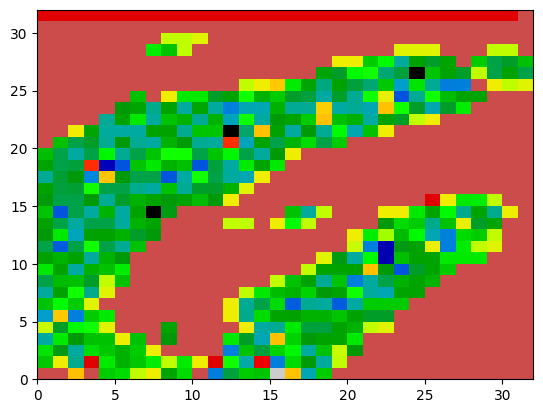

In [22]:
plt.pcolormesh(temp_data['Y_latent'][0, ..., 2], cmap=plt.cm.nipy_spectral_r)

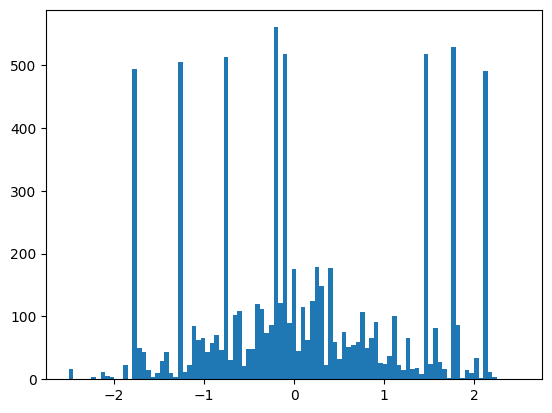

In [18]:
plt.hist(temp_data['Y_latent'].ravel(), bins=np.linspace(-2.5, 2.5, 100));

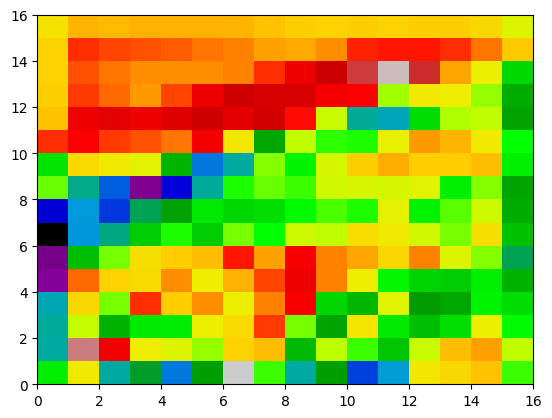

In [19]:
plt.pcolormesh(temp_data['GFS_latent'][0, ..., -1], cmap=plt.cm.nipy_spectral_r)

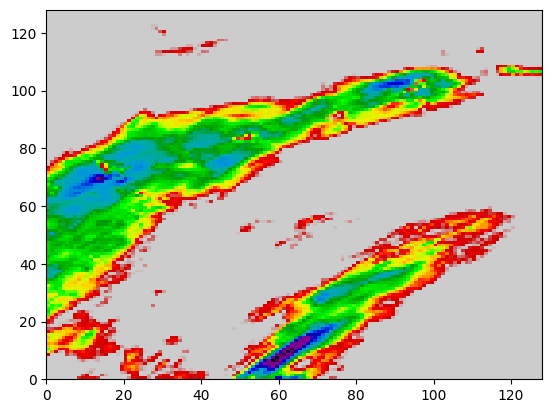

In [20]:
plt.pcolormesh(temp_data['MRMS'][0, ..., 0], cmap=plt.cm.nipy_spectral_r)